In [2]:
import scipy.optimize as opt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import requests


mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)


In [36]:
def Ierr(I):
    Ierr = np.zeros_like(I) # Defining errors based on data table from K6487 manual
    for i in range(len(I)):
        if I[i] > 1e-2:
            Ierr[i] = I[i]*0.1 + 1e-6
        elif (I[i] > 1e-3) & (I[i] < 1e-2):
            Ierr[i] = I[i]*0.1 + 1e-7
        elif (I[i] > 1e-4) & (I[i] < 1e-3):
            Ierr[i] = I[i]*0.1 + 1e-8
        elif (I[i] > 1e-5) & (I[i] < 1e-4):
            Ierr[i] = I[i]*0.1 + 1e-9
        elif (I[i] > 1e-6) & (I[i] < 1e-5):
            Ierr[i] = I[i]*0.1 + 1e-10
        elif (I[i] > 1e-7) & (I[i] < 1e-6):
            Ierr[i] = I[i]*0.1 + 1e-11
        elif (I[i] > 1e-8) & (I[i] < 1e-7):
            Ierr[i] = I[i]*0.15 + 1e-12
        elif (I[i] > 1e-9) & (I[i] < 1e-8):
            Ierr[i] = I[i]*0.15 + 1e-13
        elif (I[i] > 1e-10) & (I[i] < 1e-9):
            Ierr[i] = I[i]*0.2 + 1e-14
        else:
            Ierr[i] = I[i]*0.3 + 1e-15
    return Ierr

def getTxt(folder,file):
  path = "https://raw.githubusercontent.com/nsfuss/Phys472-Band-Gap/refs/heads/main/" + folder + "/" + file + ".txt"
  request = requests.get(path)
  temp  = np.array(request.text.split("\r\n"))
  return np.float64(np.delete(temp, np.where(temp=="")))

In [109]:
# Pulling Data
folderSi = ['2025-04-25_Si_20C','2025-04-25_Si_10C', '2025-04-23_Si_0C', '2025-04-25_Si_-10C']
folderGe = ['2025-04-25_Ge_20C', '2025-04-23_Ge_0C', '2025-04-25_Ge_-10C']

Si_I = np.zeros((len(folderSi), 200))
Si_V = np.zeros((len(folderSi), 200))
Si_T = [20,10,0,-10]

Ge_I = np.zeros((len(folderGe), 200))
Ge_V = np.zeros((len(folderGe), 200))
Ge_T = [20,0,-10]

# T = 20C
Si_I[0] = getTxt(folderSi[0],'Iavg')
Si_V[0] = getTxt(folderSi[0],'Vavg')

Ge_I[0] = getTxt(folderGe[0],'Iavg')
Ge_V[0] = getTxt(folderGe[0],'Vavg')

# T = 10C
Si_I[1] = getTxt(folderSi[1],'Iavg')
Si_V[1] = getTxt(folderSi[1],'Vavg')

# T = 0C
Si_I[2] = getTxt(folderSi[2],'Iavg')
Si_V[2] = getTxt(folderSi[2],'Vavg')

Ge_I[1] = getTxt(folderGe[1],'Iavg')
Ge_V[1] = getTxt(folderGe[1],'Vavg')

# T = -10C
Si_I[3] = getTxt(folderSi[3],'Iavg')
Si_V[3] = getTxt(folderSi[3],'Vavg')

Ge_I[2] = getTxt(folderGe[2],'Iavg')
Ge_V[2] = getTxt(folderGe[2],'Vavg')

# Errors in I

Si_Ierr = np.zeros_like(Si_I)
Ge_Ierr = np.zeros_like(Ge_I)

for j in range(len(folderSi)):
    Si_Ierr[j] = Ierr(Si_I[j])

for j in range(len(folderGe)):
    Ge_Ierr[j] = Ierr(Ge_I[j])

In [185]:
Ge_Eg = np.zeros_like(Ge_T,dtype='float64')
Ge_Egerr = np.zeros_like(Ge_T,dtype='float64')
Ge_C = np.zeros_like(Ge_T,dtype='float64')
Ge_Cerr = np.zeros_like(Ge_T,dtype='float64')

Si_Eg = np.zeros_like(Si_T,dtype='float64')
Si_Egerr = np.zeros_like(Si_T,dtype='float64')
Si_C = np.zeros_like(Si_T,dtype='float64')
Si_Cerr = np.zeros_like(Si_T,dtype='float64')

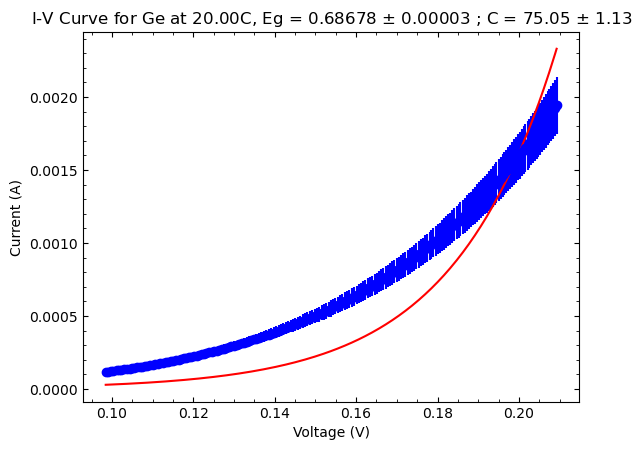

In [187]:
gineV = 0.68
guess = [gineV * 1.602e-19, 10]
n = 150
sample = 0

def IofV(V,Eg,C):
    T = Ge_T[sample] + 273.15 # temperature in Kelvin
    q = 1.602e-19 # charge of an electron in Coulombs
    k = 1.3806452e-23 # boltzman constant in J/K
    return  (C * T**(3/2) * np.exp((-Eg) / (k*T))) * (np.exp((V*q) / (k*T))-1)

popt, pcov = opt.curve_fit(IofV, Ge_V[sample][n:], Ge_I[sample][n:], p0 = guess, sigma = Ge_Ierr[sample][n:], absolute_sigma=True)

plt.errorbar(Ge_V[sample], Ge_I[sample], Ge_Ierr[0], fmt='o', color = 'b')
plt.plot(Ge_V[sample], IofV(Ge_V[sample],*popt), color='r')

popt[0] = popt[0] / 1.602e-19
pcov[0] = pcov[0] / 1.602e-19

perr = np.sqrt(np.diag(pcov))
perr[1] = popt[1]*0.015

plt.xlabel('Voltage (V)');
plt.ylabel('Current (A)');
plt.title(r'I-V Curve for Ge at %.2fC, Eg = %.5f $\pm$ %.5f ; C = %.2f $\pm$ %.2f' % (Ge_T[sample], popt[0], perr[0], popt[1], perr[1]));

Ge_Eg[sample] = popt[0]
Ge_Egerr[sample] = perr[0]
Ge_C[sample] = popt[1]
Ge_Cerr[sample] = perr[1]

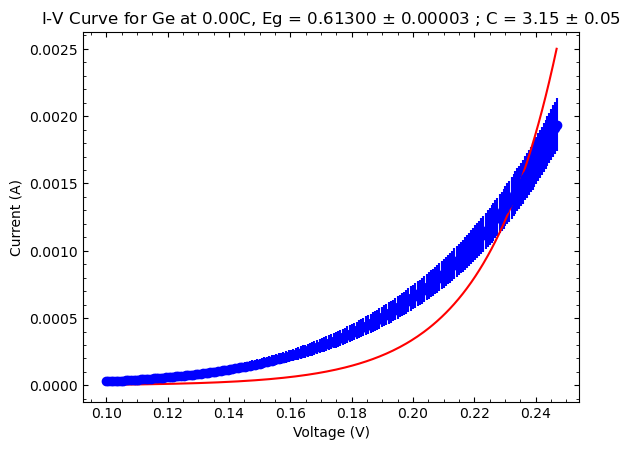

In [188]:
gineV = 0.68
guess = [gineV * 1.602e-19, 1]
n = 150
sample = 1

def IofV(V,Eg,C):
    T = Ge_T[sample] + 273.15 # temperature in Kelvin
    q = 1.602e-19 # charge of an electron in Coulombs
    k = 1.3806452e-23 # boltzman constant in J/K
    return  (C * T**(3/2) * np.exp((-Eg) / (k*T))) * (np.exp((V*q) / (k*T))-1)

popt, pcov = opt.curve_fit(IofV, Ge_V[sample][n:], Ge_I[sample][n:], p0 = guess, sigma = Ge_Ierr[sample][n:], absolute_sigma=True)

plt.errorbar(Ge_V[sample], Ge_I[sample], Ge_Ierr[0], fmt='o', color = 'b')
plt.plot(Ge_V[sample], IofV(Ge_V[sample],*popt), color='r')

popt[0] = popt[0] / 1.602e-19
pcov[0] = pcov[0] / 1.602e-19

perr = np.sqrt(np.diag(pcov))
perr[1] = popt[1]*0.015

plt.xlabel('Voltage (V)');
plt.ylabel('Current (A)');
plt.title(r'I-V Curve for Ge at %.2fC, Eg = %.5f $\pm$ %.5f ; C = %.2f $\pm$ %.2f' % (Ge_T[sample], popt[0], perr[0], popt[1], perr[1]));

Ge_Eg[sample] = popt[0]
Ge_Egerr[sample] = perr[0]
Ge_C[sample] = popt[1]
Ge_Cerr[sample] = perr[1]

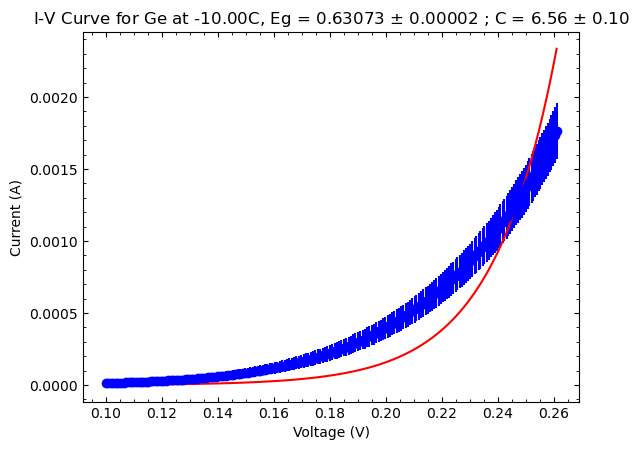

In [189]:
gineV = 0.68
guess = [gineV * 1.602e-19, 0.5]
n = 150
sample = 2

def IofV(V,Eg,C):
    T = Ge_T[sample] + 273.15 # temperature in Kelvin
    q = 1.602e-19 # charge of an electron in Coulombs
    k = 1.3806452e-23 # boltzman constant in J/K
    return  (C * T**(3/2) * np.exp((-Eg) / (k*T))) * (np.exp((V*q) / (k*T))-1)

popt, pcov = opt.curve_fit(IofV, Ge_V[sample][n:], Ge_I[sample][n:], p0 = guess, sigma = Ge_Ierr[sample][n:], absolute_sigma=True)

plt.errorbar(Ge_V[sample], Ge_I[sample], Ge_Ierr[0], fmt='o', color = 'b')
plt.plot(Ge_V[sample], IofV(Ge_V[sample],*popt), color='r')

popt[0] = popt[0] / 1.602e-19
pcov[0] = pcov[0] / 1.602e-19

perr = np.sqrt(np.diag(pcov))
perr[1] = popt[1]*0.015

plt.xlabel('Voltage (V)');
plt.ylabel('Current (A)');
plt.title(r'I-V Curve for Ge at %.2fC, Eg = %.5f $\pm$ %.5f ; C = %.2f $\pm$ %.2f' % (Ge_T[sample], popt[0], perr[0], popt[1], perr[1]));

Ge_Eg[sample] = popt[0]
Ge_Egerr[sample] = perr[0]
Ge_C[sample] = popt[1]
Ge_Cerr[sample] = perr[1]

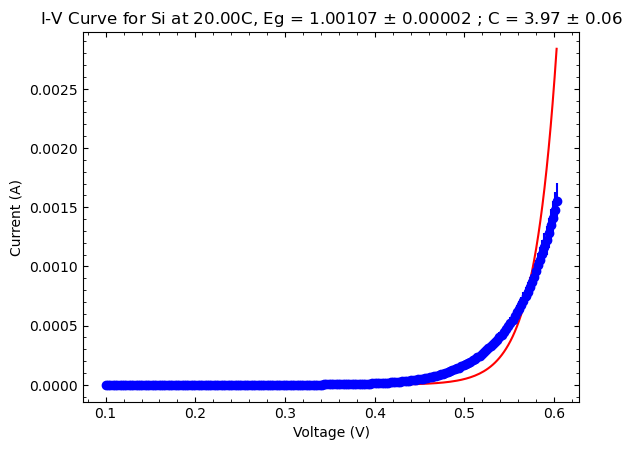

In [190]:
gineV = 1.1
guess = [gineV * 1.602e-19, 0.5]
n = 150
sample = 0

def IofV(V,Eg,C):
    T = Si_T[sample] + 273.15 # temperature in Kelvin
    q = 1.602e-19 # charge of an electron in Coulombs
    k = 1.3806452e-23 # boltzman constant in J/K
    return  (C * T**(3/2) * np.exp((-Eg) / (k*T))) * (np.exp((V*q) / (k*T))-1)

popt, pcov = opt.curve_fit(IofV, Si_V[sample][n:], Si_I[sample][n:], p0 = guess, sigma = Si_Ierr[1][n:], absolute_sigma=True)

plt.errorbar(Si_V[sample], Si_I[sample], np.absolute(Si_Ierr[sample]), fmt='o', color = 'b')
plt.plot(Si_V[sample], IofV(Si_V[sample],*popt), color='r')

popt[0] = popt[0] / 1.602e-19
pcov[0] = pcov[0] / 1.602e-19

perr = np.sqrt(np.diag(pcov))
perr[1] = popt[1]*0.015

plt.xlabel('Voltage (V)');
plt.ylabel('Current (A)');
plt.title(r'I-V Curve for Si at %.2fC, Eg = %.5f $\pm$ %.5f ; C = %.2f $\pm$ %.2f' % (Si_T[sample], popt[0], perr[0], popt[1], perr[1]));

Si_Eg[sample] = popt[0]
Si_Egerr[sample] = perr[0]
Si_C[sample] = popt[1]
Si_Cerr[sample] = perr[1]


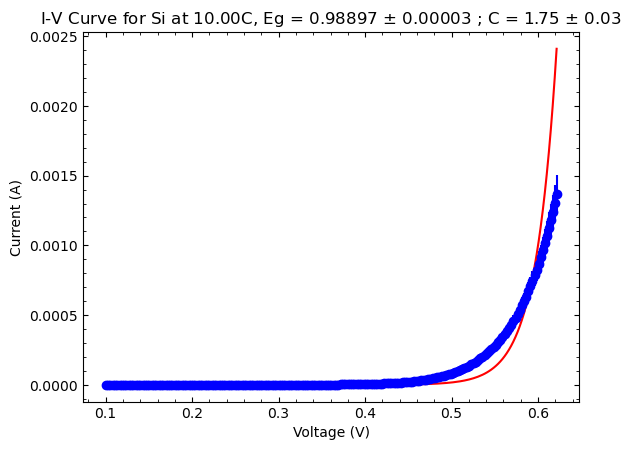

In [191]:
gineV = 1.1
guess = [gineV * 1.602e-19, 0.2]
n = 150
sample = 1

def IofV(V,Eg,C):
    T = Si_T[sample] + 273.15 # temperature in Kelvin
    q = 1.602e-19 # charge of an electron in Coulombs
    k = 1.3806452e-23 # boltzman constant in J/K
    return  (C * T**(3/2) * np.exp((-Eg) / (k*T))) * (np.exp((V*q) / (k*T))-1)

popt, pcov = opt.curve_fit(IofV, Si_V[sample][n:], Si_I[sample][n:], p0 = guess, sigma = Si_Ierr[1][n:], absolute_sigma=True)

plt.errorbar(Si_V[sample], Si_I[sample], np.absolute(Si_Ierr[sample]), fmt='o', color = 'b')
plt.plot(Si_V[sample], IofV(Si_V[sample],*popt), color='r')

popt[0] = popt[0] / 1.602e-19
pcov[0] = pcov[0] / 1.602e-19

perr = np.sqrt(np.diag(pcov))
perr[1] = popt[1]*0.015

plt.xlabel('Voltage (V)');
plt.ylabel('Current (A)');
plt.title(r'I-V Curve for Si at %.2fC, Eg = %.5f $\pm$ %.5f ; C = %.2f $\pm$ %.2f' % (Si_T[sample], popt[0], perr[0], popt[1], perr[1]));

Si_Eg[sample] = popt[0]
Si_Egerr[sample] = perr[0]
Si_C[sample] = popt[1]
Si_Cerr[sample] = perr[1]

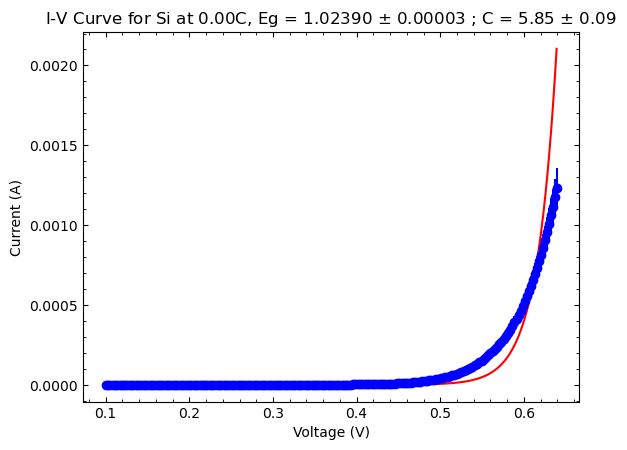

In [192]:
gineV = 1.1
guess = [gineV * 1.602e-19, 0.8]
n = 150
sample = 2

def IofV(V,Eg,C):
    T = Si_T[sample] + 273.15 # temperature in Kelvin
    q = 1.602e-19 # charge of an electron in Coulombs
    k = 1.3806452e-23 # boltzman constant in J/K
    return  (C * T**(3/2) * np.exp((-Eg) / (k*T))) * (np.exp((V*q) / (k*T))-1)

popt, pcov = opt.curve_fit(IofV, Si_V[sample][n:], Si_I[sample][n:], p0 = guess, sigma = Si_Ierr[1][n:], absolute_sigma=True)

plt.errorbar(Si_V[sample], Si_I[sample], np.absolute(Si_Ierr[sample]), fmt='o', color = 'b')
plt.plot(Si_V[sample], IofV(Si_V[sample],*popt), color='r')

popt[0] = popt[0] / 1.602e-19
pcov[0] = pcov[0] / 1.602e-19

perr = np.sqrt(np.diag(pcov))
perr[1] = popt[1]*0.015

plt.xlabel('Voltage (V)');
plt.ylabel('Current (A)');
plt.title(r'I-V Curve for Si at %.2fC, Eg = %.5f $\pm$ %.5f ; C = %.2f $\pm$ %.2f' % (Si_T[sample], popt[0], perr[0], popt[1], perr[1]));

Si_Eg[sample] = popt[0]
Si_Egerr[sample] = perr[0]
Si_C[sample] = popt[1]
Si_Cerr[sample] = perr[1]

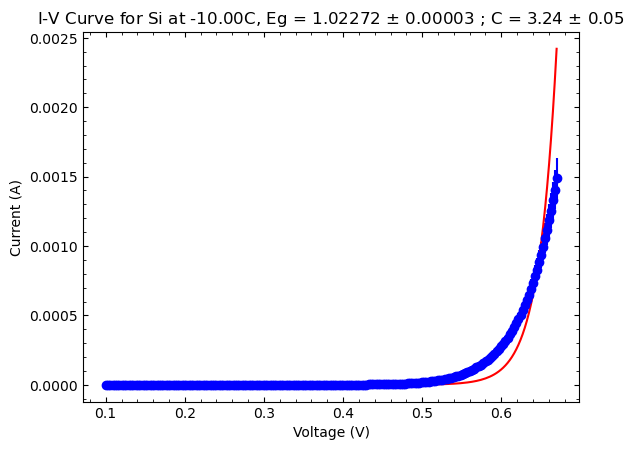

In [193]:
gineV = 1.1
guess = [gineV * 1.602e-19, 0.5]
n = 150
sample = 3

def IofV(V,Eg,C):
    T = Si_T[sample] + 273.15 # temperature in Kelvin
    q = 1.602e-19 # charge of an electron in Coulombs
    k = 1.3806452e-23 # boltzman constant in J/K
    return  (C * T**(3/2) * np.exp((-Eg) / (k*T))) * (np.exp((V*q) / (k*T))-1)

popt, pcov = opt.curve_fit(IofV, Si_V[sample][n:], Si_I[sample][n:], p0 = guess, sigma = Si_Ierr[1][n:], absolute_sigma=True)

plt.errorbar(Si_V[sample], Si_I[sample], np.absolute(Si_Ierr[sample]), fmt='o', color = 'b')
plt.plot(Si_V[sample], IofV(Si_V[sample],*popt), color='r')

popt[0] = popt[0] / 1.602e-19
pcov[0] = pcov[0] / 1.602e-19

perr = np.sqrt(np.diag(pcov))
perr[1] = popt[1]*0.015

plt.xlabel('Voltage (V)');
plt.ylabel('Current (A)');
plt.title(r'I-V Curve for Si at %.2fC, Eg = %.5f $\pm$ %.5f ; C = %.2f $\pm$ %.2f' % (Si_T[sample], popt[0], perr[0], popt[1], perr[1]));

Si_Eg[sample] = popt[0]
Si_Egerr[sample] = perr[0]
Si_C[sample] = popt[1]
Si_Cerr[sample] = perr[1]

In [198]:
# Averages
print('Average value of Germanium Band Gap over all temperature data, %.5f with an error of %.5f)' % (np.average(Ge_Eg), np.average(Ge_Egerr)))
print('Average value of Germanium Scaling Constant over all temperature data, %.2f with an error of %.2f)' % (np.average(Ge_C), np.average(Ge_Cerr)))

print('Average value of Germanium Band Gap over all temperature data, %.5f with an error of %.5f)' % (np.average(Si_Eg), np.average(Si_Egerr)))
print('Average value of Germanium Scaling Constant over all temperature data, %.2f with an error of %.2f)' % (np.average(Si_C), np.average(Si_Cerr)))

Average value of Germanium Band Gap over all temperature data, 0.64350 with an error of 0.00003)
Average value of Germanium Scaling Constant over all temperature data, 28.25 with an error of 0.42)
Average value of Germanium Band Gap over all temperature data, 1.00916 with an error of 0.00003)
Average value of Germanium Scaling Constant over all temperature data, 3.70 with an error of 0.06)
